## Start off with key imports and enforcement of rcparams

In [13]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import lightkurve as lk
from astropy.io import ascii
from astropy.table import Table
from astropy.time import Time
import astropy.units as u

os.chdir(pathlib.Path.cwd())
def set_rcparams():
    tab = Table.read('../../rcparams.txt', format='csv')
    for i in range(len(tab)):
        try:
            plt.rcParams[tab['key'][i]] = float(tab['val'][i])
        except ValueError:
            plt.rcParams[tab['key'][i]] = str(tab['val'][i])
    return
set_rcparams()

## Data (after running `twirler.py` on the g', r', i' and processing all them+J/C filters in AIJ)

### Note, in the `*_badfiles` objects we remove a subset of images from each output-AIJ light curve. See Sec. 2.1.1 in Schochet & Feinstein (in prep) for an explanation of why this was necessary

In [14]:
#gp
# ---
gp_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/gp.xls')
gp_data.sort(keys='rel_flux_T1')
gp_badfiles = [str(val) for val in list(gp_data[:2]['Label'])]

gp_cleaned = gp_data[2:] # Remove any frames where AIJ misplaced the aperture and T1 or C2 fluxes are negative/near-0
gp_cleaned.sort(keys='J.D.-2400000')
gp_d, gp_aum_flux, gp_c1_flux = gp_cleaned['J.D.-2400000'], gp_cleaned['rel_flux_T1'], gp_cleaned['rel_flux_C2']
gp_aum_err = gp_cleaned['rel_flux_err_T1']

# ---

#ip
# ---
ip_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/ip.xls')
ip_data.sort(keys='rel_flux_T1')
ip_badfiles = [str(val) for val in list(ip_data[:28]['Label'])]
ip_badfiles.append(ip_data[len(ip_data)-1]["Label"])

ip_cleaned = ip_data[28:len(ip_data)-1] # Same as above but there is a +40 value out of nowhere, don't think that is real
ip_cleaned.sort(keys='J.D.-2400000')
ip_d, ip_aum_flux, ip_c1_flux = ip_cleaned['J.D.-2400000'], ip_cleaned['rel_flux_T1'], ip_cleaned['rel_flux_C2']
ip_aum_err = ip_cleaned['rel_flux_err_T1']

# ---
#rp
# ---
rp_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/rp.xls')
rp_data.sort(keys='rel_flux_T1')
rp_badfiles = [str(val) for val in list(rp_data[:1]['Label'])]

rp_cleaned = rp_data[1:] # Same as above but there is only one bad value
rp_cleaned.sort(keys='J.D.-2400000')
rp_d, rp_aum_flux, rp_c1_flux = rp_cleaned['J.D.-2400000'], rp_cleaned['rel_flux_T1'], rp_cleaned['rel_flux_C2']
rp_aum_err = rp_cleaned['rel_flux_err_T1']

# ---
#U
# ---
U_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/U.xls')
U_data.sort(keys='rel_flux_T1')
U_badfiles = [str(val) for val in list(U_data[(len(U_data))-13:]['Label'])]
U_badfiles.append(U_data[0]["Label"])
U_badfiles.append(U_data[1]["Label"])


U_cleaned = U_data[2:(len(U_data))-13] # Same as above but there are 13 values with substantially too large flux values, and 2 with values too low 
U_cleaned.sort(keys='J.D.-2400000')
U_d, U_aum_flux, U_c1_flux = U_cleaned['J.D.-2400000'], U_cleaned['rel_flux_T1'], U_cleaned['rel_flux_C2']
U_aum_err = U_cleaned['rel_flux_err_T1']

# ---
#B
# ---
B_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/B.xls')

B_cleaned = B_data.copy()
B_cleaned.sort(keys='J.D.-2400000')
B_d, B_aum_flux, B_c1_flux = B_cleaned['J.D.-2400000'], B_cleaned['rel_flux_T1'], B_cleaned['rel_flux_C2']
B_aum_err = B_cleaned['rel_flux_err_T1']

# ---
#V
# ---
V_data = ascii.read('/Users/mschochet/Desktop/MSU_PHD/lco_aumic/lcs_posttwirl/V.xls')

V_cleaned = V_data.copy()
V_cleaned.sort(keys='J.D.-2400000')
V_d, V_aum_flux, V_c1_flux = V_cleaned['J.D.-2400000'], V_cleaned['rel_flux_T1'], V_cleaned['rel_flux_C2']
V_aum_err = V_cleaned['rel_flux_err_T1']
# ---

### Old bin method

In [15]:
''' Old method for binning, whereby we just turned days into integer day values (dropping the fractional JD component). This method is not used in the paper, 
but is kept here for future reference. 
'''

'''
gp_ds = [int(d) for d in gp_d]
ip_ds = [int(d) for d in ip_d]
rp_ds = [int(d) for d in rp_d]
U_ds = [int(d) for d in U_d]
B_ds = [int(d) for d in B_d]
V_ds = [int(d) for d in V_d]

def binned_lc(dates, fluxes, errors):
    current_date = 0
    returned_binnedlc = pd.DataFrame(data={"flux":[], "times":[], "errs":[]})
    flux_counter = 0
    num_counter = 0
    error_counter = 0
    for num, date in enumerate(dates):
        if current_date != date:
            if ((flux_counter!=0) & (num_counter!=0)):
                returned_binnedlc.loc[len(returned_binnedlc)] = [flux_counter/num_counter, current_date, error_counter/num_counter]
            flux_counter = 0
            num_counter = 0
            error_counter = 0
            current_date = date
        else:
            flux_counter+=fluxes[num]
            error_counter+=errors[num]     
            num_counter+=1 
    fluxes = [val for val in returned_binnedlc['flux'].values]
    errors = [val for val in returned_binnedlc['errs'].values]
    times = [int(val) for val in returned_binnedlc['times'].values]
    final = lk.LightCurve(time=times, flux=fluxes, flux_err=errors)
    folded_fin = final.fold(4.86, epoch_time=2400000, epoch_phase=1)
    return final, folded_fin
'''

'\ngp_ds = [int(d) for d in gp_d]\nip_ds = [int(d) for d in ip_d]\nrp_ds = [int(d) for d in rp_d]\nU_ds = [int(d) for d in U_d]\nB_ds = [int(d) for d in B_d]\nV_ds = [int(d) for d in V_d]\n\ndef binned_lc(dates, fluxes, errors):\n    current_date = 0\n    returned_binnedlc = pd.DataFrame(data={"flux":[], "times":[], "errs":[]})\n    flux_counter = 0\n    num_counter = 0\n    error_counter = 0\n    for num, date in enumerate(dates):\n        if current_date != date:\n            if ((flux_counter!=0) & (num_counter!=0)):\n                returned_binnedlc.loc[len(returned_binnedlc)] = [flux_counter/num_counter, current_date, error_counter/num_counter]\n            flux_counter = 0\n            num_counter = 0\n            error_counter = 0\n            current_date = date\n        else:\n            flux_counter+=fluxes[num]\n            error_counter+=errors[num]     \n            num_counter+=1 \n    fluxes = [val for val in returned_binnedlc[\'flux\'].values]\n    errors = [val for v

### Current bin method (in paper)

In [16]:
def binned_lc(datelist, fluxes, errors):
    returned_binnedlc = pd.DataFrame(data={"flux":[], "times":[], "errs":[]})
    date_counter, flux_counter, num_counter, error_counter  = 0, 0, 0, 0
    for num, dates in enumerate(datelist):
        if num==0:
            flux_counter+=fluxes[num]
            date_counter+=dates
            error_counter+=errors[num]     
            num_counter+=1
        else:
            datediffs = np.diff(datelist) 
            if datediffs[num-1] > 0.45:
                if ((flux_counter!=0) & (num_counter!=0)):
                    returned_binnedlc.loc[len(returned_binnedlc)] = [flux_counter/num_counter, date_counter/num_counter, error_counter/num_counter]
                date_counter, flux_counter, num_counter, error_counter  = 0, 0, 0, 0
            else:
                flux_counter+=fluxes[num]
                date_counter+=dates
                error_counter+=errors[num]     
                num_counter+=1
    fluxes = [val for val in returned_binnedlc['flux'].values]
    errors = [val for val in returned_binnedlc['errs'].values]
    times = [val for val in returned_binnedlc['times'].values]
    final = lk.LightCurve(time=times, flux=fluxes, flux_err=errors)
    folded_fin = final.fold(4.86, epoch_time=2400000, epoch_phase=1)
    return final, folded_fin

In [17]:
gp_binned, gp_folded = binned_lc(gp_d, gp_aum_flux, gp_aum_err)
rp_binned, rp_folded = binned_lc(rp_d, rp_aum_flux, rp_aum_err)
ip_binned, ip_folded = binned_lc(ip_d, ip_aum_flux, ip_aum_err)
U_binned, U_folded = binned_lc(U_d, U_aum_flux, U_aum_err)
B_binned, B_folded = binned_lc(B_d, B_aum_flux, B_aum_err)
V_binned, V_folded = binned_lc(V_d, V_aum_flux, V_aum_err)

# save the binned and folded files
gp_binned.to_csv('../../binned_lcs/gp.csv', overwrite=True) 
ip_binned.to_csv('../../binned_lcs/ip.csv', overwrite=True) 
rp_binned.to_csv('../../binned_lcs/rp.csv', overwrite=True) 
U_binned.to_csv('../../binned_lcs/U.csv', overwrite=True) 
B_binned.to_csv('../../binned_lcs/B.csv', overwrite=True) 
V_binned.to_csv('../../binned_lcs/V.csv', overwrite=True) 

gp_folded.to_csv('../../folded_lcs/gp.csv', overwrite=True) 
ip_folded.to_csv('../../folded_lcs/ip.csv', overwrite=True) 
rp_folded.to_csv('../../folded_lcs/rp.csv', overwrite=True) 
U_folded.to_csv('../../folded_lcs/U.csv', overwrite=True) 
B_folded.to_csv('../../folded_lcs/B.csv', overwrite=True) 
V_folded.to_csv('../../folded_lcs/V.csv', overwrite=True) 

# normalize the folded lcs by median flux at phases between 0.5-1.0 in time
gp_folded /= np.median(gp_folded[(gp_folded['time'] > 0.5) &  (gp_folded['time'] < 1.0)]['flux'])
ip_folded /= np.median(ip_folded[(ip_folded['time'] > 0.5) &  (ip_folded['time'] < 1.0)]['flux'])
rp_folded /= np.median(rp_folded[(rp_folded['time'] > 0.5) &  (rp_folded['time'] < 1.0)]['flux'])
U_folded /= np.median(U_folded[(U_folded['time'] > 0.5) &  (U_folded['time'] < 1.0)]['flux'])
B_folded /= np.median(B_folded[(B_folded['time'] > 0.5) &  (B_folded['time'] < 1.0)]['flux'])
V_folded /= np.median(V_folded[(V_folded['time'] > 0.5) &  (V_folded['time'] < 1.0)]['flux'])

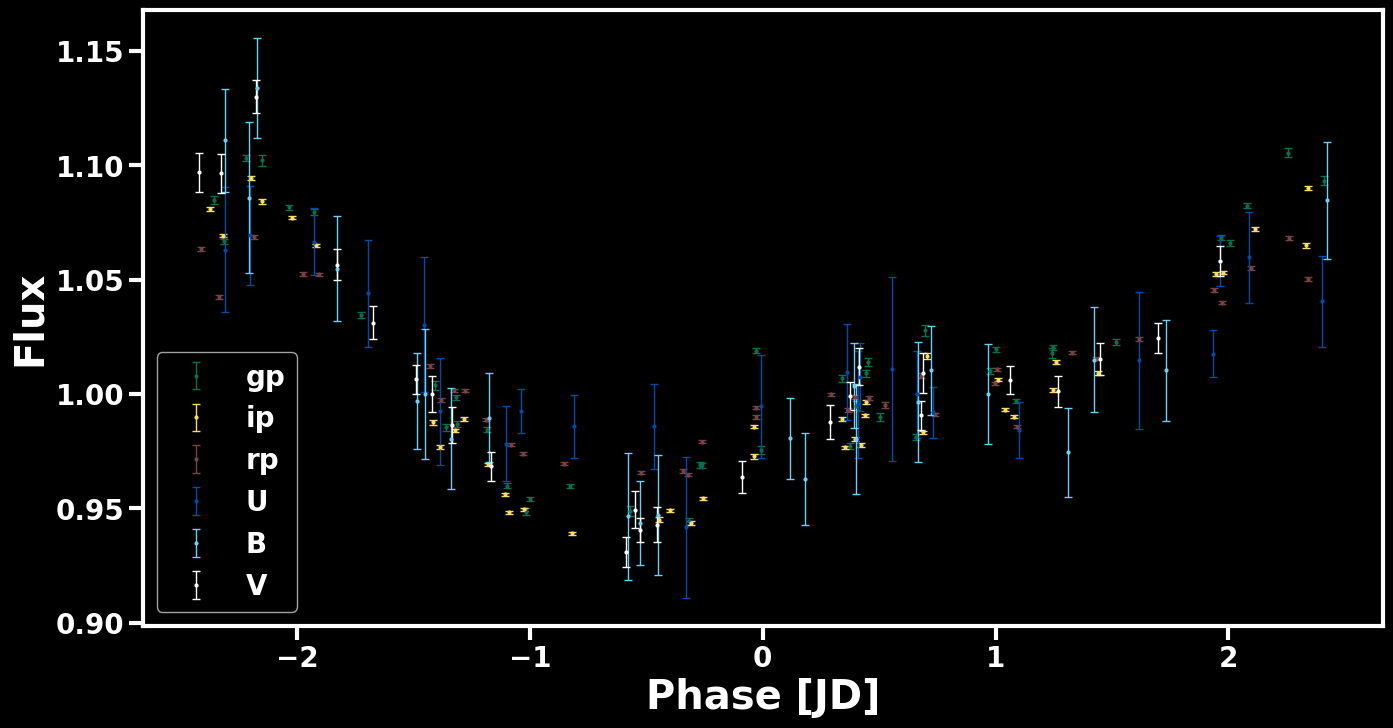

In [18]:
%matplotlib inline
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 8))

gp_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='gp', c='#0B6E4F')
rp_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='ip', c='#F9DB6D')
ip_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='rp', c='#764248')

U_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='U', c="#004BA8")
B_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='B' , c="#6CCFF6")
V_folded.errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='V' , c="#FFFFFF")


ax.legend()

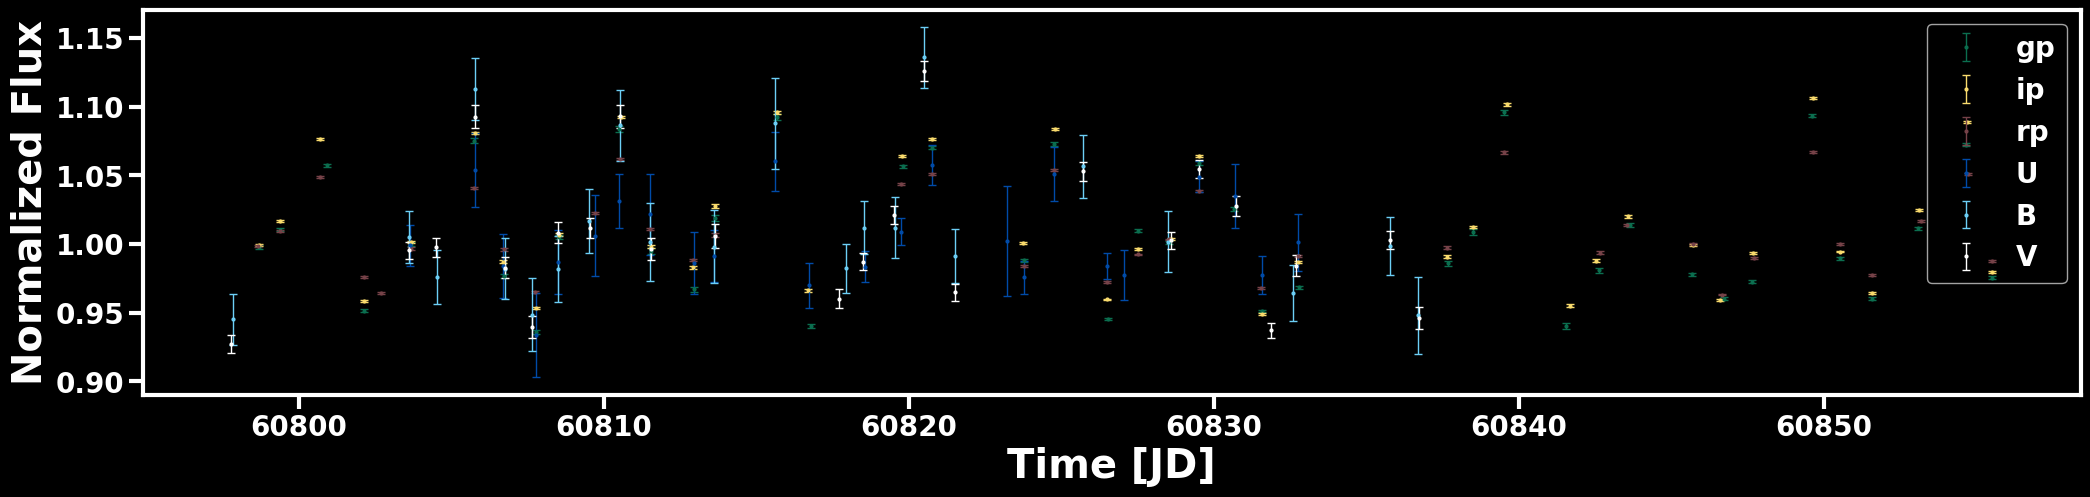

In [19]:
%matplotlib inline
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(25, 5))


gp_binned.normalize().errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='gp', c='#0B6E4F')
rp_binned.normalize().errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='ip', c='#F9DB6D')
ip_binned.normalize().errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='rp', c='#764248')

U_binned.normalize().errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='U', c="#004BA8")
B_binned.normalize().errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='B' , c="#6CCFF6")
V_binned.normalize().errorbar(ax=ax, fmt='o', elinewidth=1, capsize=3, label='V' , c="#FFFFFF")


ax.legend()

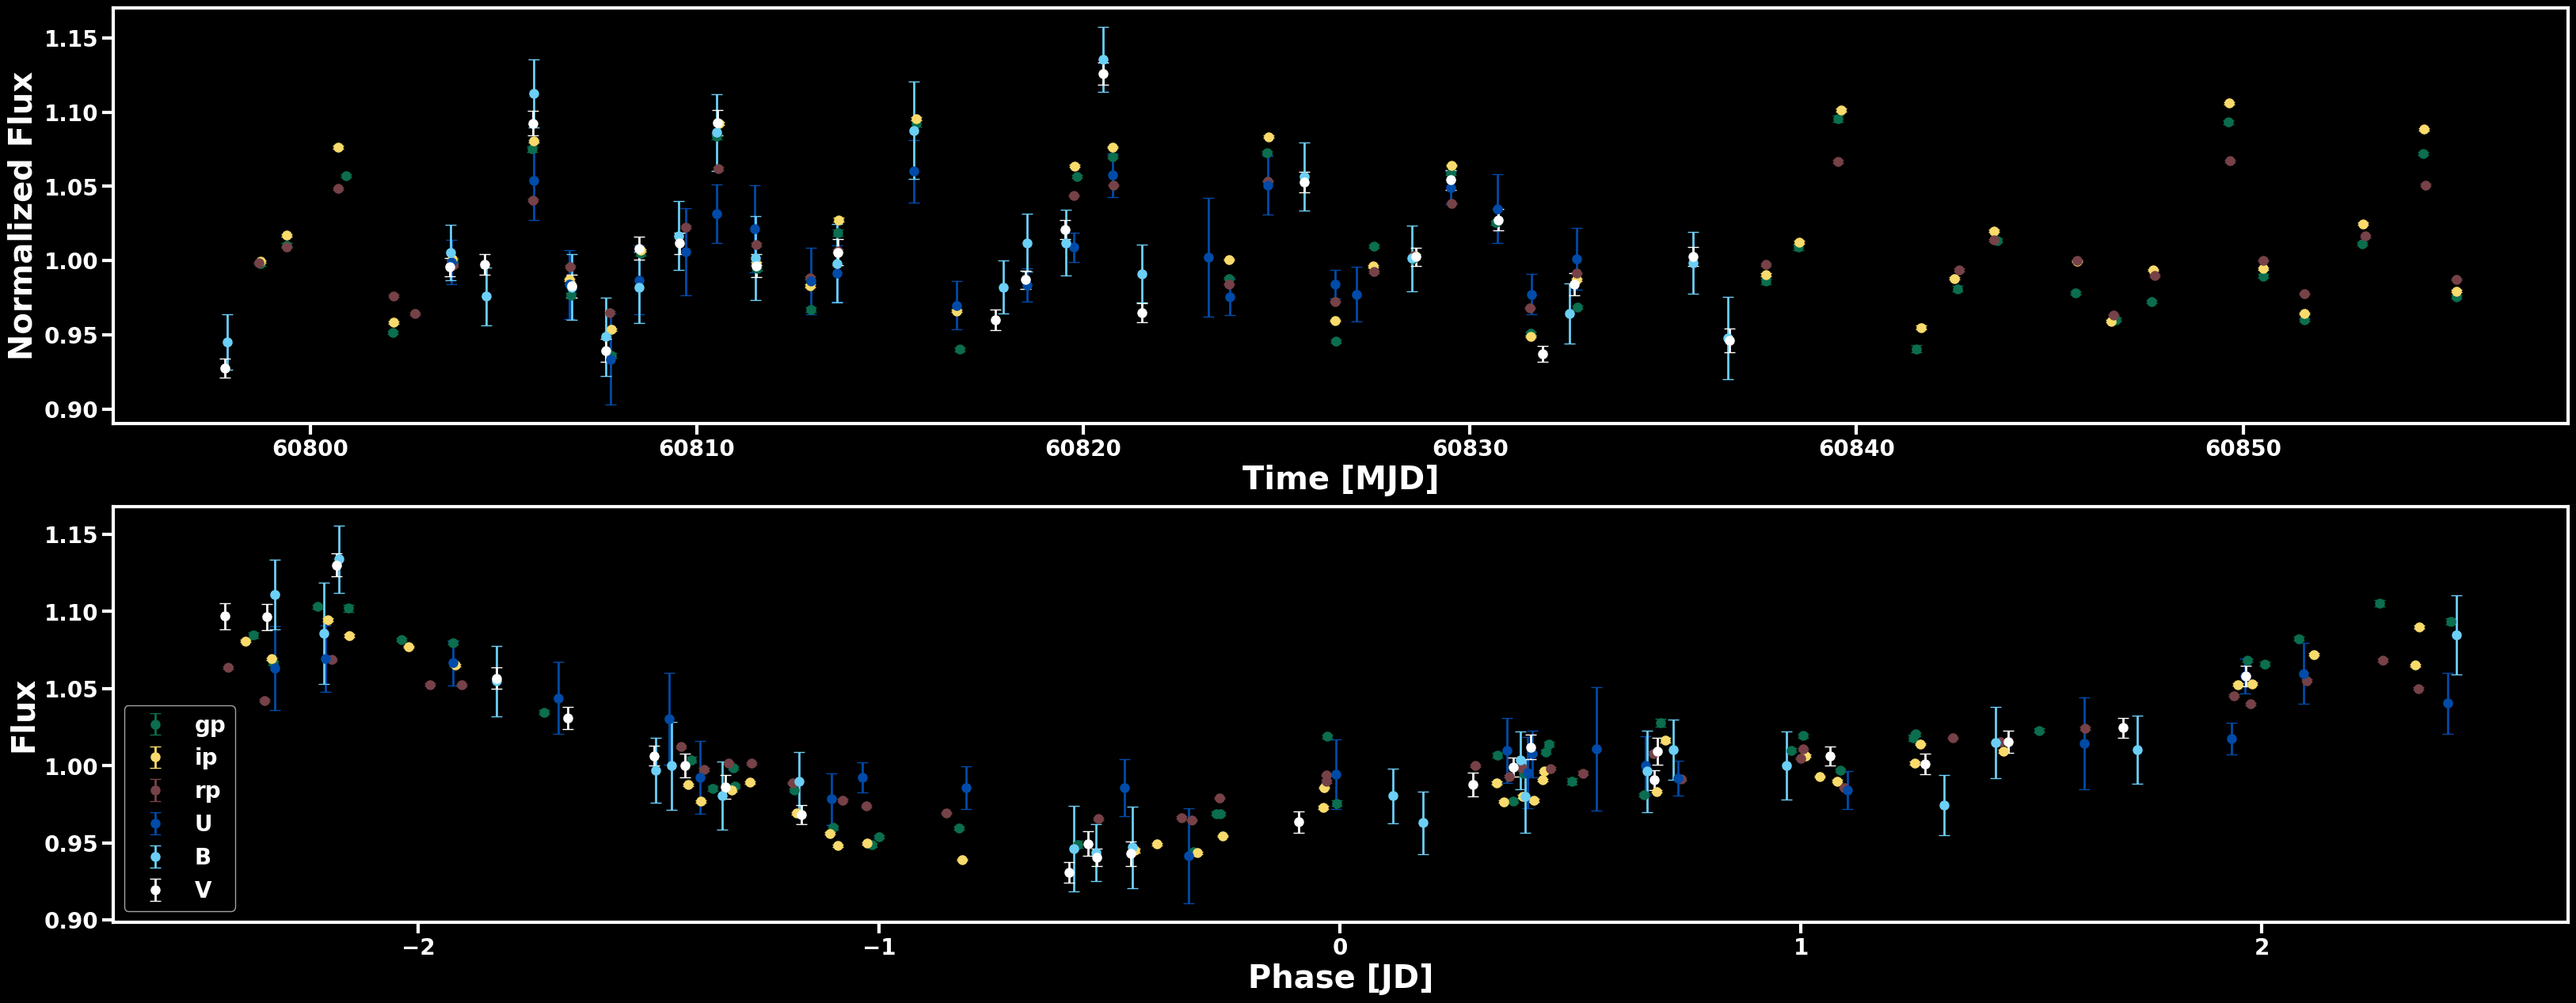

In [20]:
%matplotlib inline
plt.style.use('dark_background')
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(40, 15))


gp_binned.normalize().errorbar(ax=ax1, markersize=8, fmt='o', elinewidth=2, capsize=5, c='#0B6E4F')
rp_binned.normalize().errorbar(ax=ax1, markersize=8, fmt='o', elinewidth=2, capsize=5, c='#F9DB6D')
ip_binned.normalize().errorbar(ax=ax1, markersize=8, fmt='o', elinewidth=2, capsize=5, c='#764248')

U_binned.normalize().errorbar(ax=ax1, markersize=8, fmt='o', elinewidth=2, capsize=5, c="#004BA8")
B_binned.normalize().errorbar(ax=ax1, markersize=8, fmt='o', elinewidth=2, capsize=5, c="#6CCFF6")
V_binned.normalize().errorbar(ax=ax1, markersize=8, fmt='o', elinewidth=2, capsize=5, c="#FFFFFF")


gp_folded.errorbar(ax=ax2, markersize=8, fmt='o', elinewidth=2, capsize=5, label='gp', c='#0B6E4F')
rp_folded.errorbar(ax=ax2, markersize=8, fmt='o', elinewidth=2, capsize=5, label='ip', c='#F9DB6D')
ip_folded.errorbar(ax=ax2, markersize=8, fmt='o', elinewidth=2, capsize=5, label='rp', c='#764248')

U_folded.errorbar(ax=ax2, markersize=8, fmt='o', elinewidth=2, capsize=5, label='U', c="#004BA8")
B_folded.errorbar(ax=ax2, markersize=8, fmt='o', elinewidth=2, capsize=5, label='B' , c="#6CCFF6")
V_folded.errorbar(ax=ax2, markersize=8, fmt='o', elinewidth=2, capsize=5, label='V' , c="#FFFFFF")

ax1.set_xlabel('Time [MJD]')
ax2.legend(fontsize=20)